In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from math import floor
from PIL import Image
import random

In [2]:
use_google_colab = False

if use_google_colab==True:
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_project = '/content/drive/MyDrive/School/1. University/Year 4/Semester 2/APS360 - Applied Fundamentals of Deep Learning/Project/'
else:
    # When using on local machine. Folder 'split_data' must be in the same dir as this file.
    path_to_project=""
    
print(path_to_project)

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

mps


In [4]:
def count_images_and_percentage_with_partition(root):
    partitions = ['train', 'val', 'test']
    classes = ['Glass', 'Metal', 'Paper', 'Plastic']
    total_images = 0
    partition_totals = {}
    counts = {}

    # Count the images in each partition and class
    for partition in partitions:
        partition_counts = {}
        partition_total = 0
        for class_name in classes:
            class_path = os.path.join(root, 'split_data', partition, class_name)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            count = len(image_files)
            partition_counts[class_name] = count
            partition_total += count
        counts[partition] = partition_counts
        partition_totals[partition] = partition_total
        total_images += partition_total

    # Print counts and percentages
    for partition, partition_counts in counts.items():
        print(f"'{partition}' partition: {partition_totals[partition]} images, {(partition_totals[partition] / total_images) * 100:.2f}% of total")
        for class_name, count in partition_counts.items():
            percentage = (count / partition_totals[partition]) * 100
            print(f" - {class_name}: {count} images, {percentage:.2f}% of partition")
        print()

    print(f"Total images across all partitions: {total_images}")

In [5]:
count_images_and_percentage_with_partition(path_to_project)

'train' partition: 2654 images, 69.97% of total
 - Glass: 649 images, 24.45% of partition
 - Metal: 683 images, 25.73% of partition
 - Paper: 658 images, 24.79% of partition
 - Plastic: 664 images, 25.02% of partition

'val' partition: 586 images, 15.45% of total
 - Glass: 143 images, 24.40% of partition
 - Metal: 151 images, 25.77% of partition
 - Paper: 145 images, 24.74% of partition
 - Plastic: 147 images, 25.09% of partition

'test' partition: 553 images, 14.58% of total
 - Glass: 136 images, 24.59% of partition
 - Metal: 142 images, 25.68% of partition
 - Paper: 137 images, 24.77% of partition
 - Plastic: 138 images, 24.95% of partition

Total images across all partitions: 3793


In [6]:
# Modified from Lab 3
def get_trash_data_loader(batch_size, img_dim):
    """
    Returns data loaders for the training, validation, and test datasets for the trash classification project.

    Args:
        batch_size: The number of samples per batch to load.
        img_dim: Size to resize the incoming images to. E.g., if using LargeNet128, img_dim=128

    Returns:
        train_loader: DataLoader for the training set
        val_loader: DataLoader for the validation set
        test_loader: DataLoader for the test set
    """
    # Transforms
    transform = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),  # Resize to img_dim x img_dim.
        transforms.RandomHorizontalFlip(p=0.5), # Random horizontal flip 50% chance
        transforms.RandomRotation(45),          # Random rotation by 45 degrees
        transforms.ToTensor(),                  # Convert images to tensor
    ])

    # Paths to the folders. Each class needs to have its own folder. Eg split_data/train/Glass
    train_dataset = datasets.ImageFolder(f'{path_to_project}split_data/train', transform=transform)
    val_dataset = datasets.ImageFolder(f'{path_to_project}split_data/val', transform=transform)
    test_dataset = datasets.ImageFolder(f'{path_to_project}split_data/test', transform=transform)

    # Create data loaders
    # https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
    num_workers = 4
    pin_memory = True if device == 'cuda' else False
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    
    return train_loader, val_loader, test_loader

In [7]:
class LargeNet256(nn.Module):
    def __init__(self):
        super(LargeNet256, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=10 * 30 * 30, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #convolution, relu activation, max pooling
        x = self.pool(F.relu(self.conv2(x))) #convolution, relu activation, max pooling
        x = x.view(-1, 10 * 30 * 30)
        x = F.relu(self.fc1(x)) #linear, relu activation
        x = self.fc2(x) #linear

        return x

In [8]:
# 128x128 images
class LargeNet128(nn.Module):
    def __init__(self):
        super(LargeNet128, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=10 * 14 * 14, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 14 * 14) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [9]:
def plot_training_curve(config, train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation losses and accuracies."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def train(model, train_loader, valid_loader, config):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

    best_valid_loss = float('inf')
    best_valid_acc = 0

    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []

    for epoch in range(config['num_epochs']):
        start_of_epoch = time.process_time()
        
        model.train()  # Set model to training mode
        total_train_loss, total_train_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_correct += (predicted == labels).sum().item()

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate training accuracy
        train_accuracy = total_train_correct / (len(train_loader.dataset))
        train_accs.append(train_accuracy)

        # Set model to evaluation mode
        model.eval()
        total_valid_loss, total_valid_correct = 0, 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_valid_correct += (predicted == labels).sum().item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_accuracy = total_valid_correct / (len(valid_loader.dataset))
        valid_losses.append(avg_valid_loss)
        valid_accs.append(valid_accuracy)

        # Update best validation loss and accuracy
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_valid_acc = valid_accuracy

        time_elapsed = time.process_time() - start_of_epoch
        print(f"Epoch {epoch+1}/{config['num_epochs']} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_valid_loss:.4f} | Train Acc: {train_accuracy:.4f} | Validation Acc: {valid_accuracy:.4f} | Time: {time_elapsed:.4f}")

    # Training curve plot
    plot_training_curve(config, train_losses, valid_losses, train_accs, valid_accs)

    return best_valid_loss, best_valid_acc

Getting data loaders for current config...
Time to get data loaders: 0.016783000000000214


Epoch 1/30 | Train Loss: 1.3987 | Validation Loss: 1.3920 | Train Acc: 0.2457 | Validation Acc: 0.2577 | Time: 0.4076
Epoch 2/30 | Train Loss: 1.3865 | Validation Loss: 1.3921 | Train Acc: 0.2453 | Validation Acc: 0.2577 | Time: 0.3231
Epoch 3/30 | Train Loss: 1.3868 | Validation Loss: 1.3885 | Train Acc: 0.2573 | Validation Acc: 0.2577 | Time: 0.3084
Epoch 4/30 | Train Loss: 1.3874 | Validation Loss: 1.3885 | Train Acc: 0.2573 | Validation Acc: 0.2577 | Time: 0.3300
Epoch 5/30 | Train Loss: 1.3871 | Validation Loss: 1.3833 | Train Acc: 0.2476 | Validation Acc: 0.2577 | Time: 0.3031
Epoch 6/30 | Train Loss: 1.3870 | Validation Loss: 1.3838 | Train Acc: 0.2494 | Validation Acc: 0.2577 | Time: 0.3704
Epoch 7/30 | Train Loss: 1.3867 | Validation Loss: 1.3898 | Train Acc: 0.2532 | Validation Acc: 0.2440 | Time: 0.3358
Epoch 8/30 | Train Loss: 1.3850 | Validation Loss: 1.3770 | Train Acc: 0.2724 | Validation Acc: 0.3345 | Time: 0.3691
Epoch 9/30 | Train Loss: 1.3767 | Validation Loss: 1.369

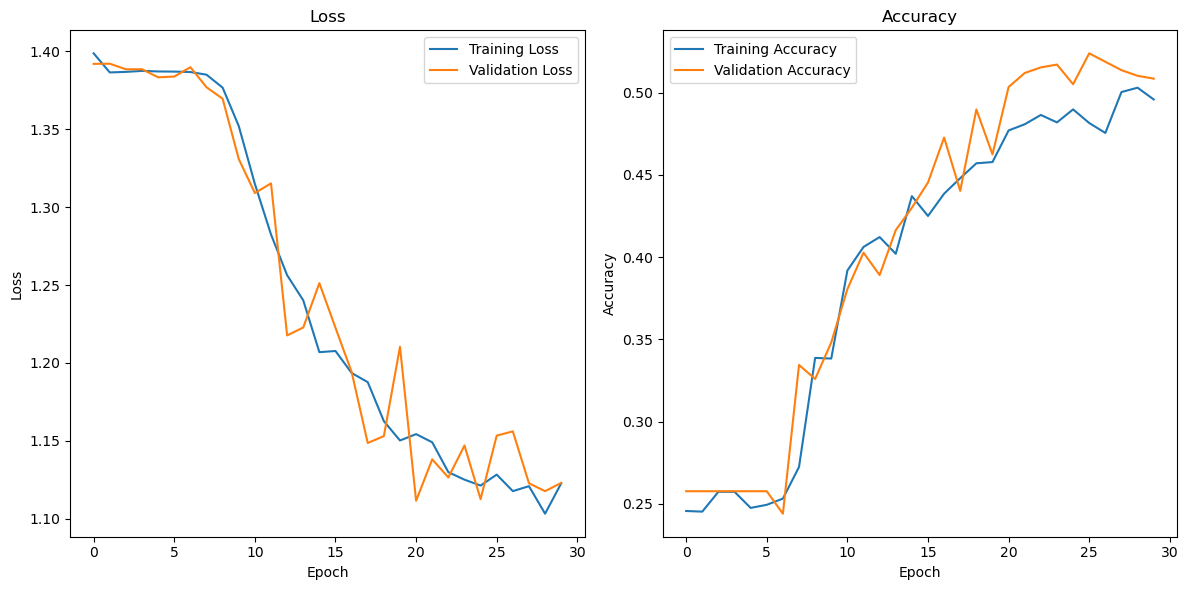

Model saved to model_LargeNet256_lr=0.001_epochs=30_batch=256.pth
Time elapsed: 12.854500999999999
Getting data loaders for current config...
Time to get data loaders: 0.25850499999999954
Epoch 1/30 | Train Loss: 1.3850 | Validation Loss: 1.3834 | Train Acc: 0.2664 | Validation Acc: 0.2594 | Time: 0.3691
Epoch 2/30 | Train Loss: 1.3517 | Validation Loss: 1.3158 | Train Acc: 0.3157 | Validation Acc: 0.3993 | Time: 0.3015
Epoch 3/30 | Train Loss: 1.2807 | Validation Loss: 1.2297 | Train Acc: 0.3998 | Validation Acc: 0.4676 | Time: 0.3270
Epoch 4/30 | Train Loss: 1.2388 | Validation Loss: 1.1960 | Train Acc: 0.4152 | Validation Acc: 0.3925 | Time: 0.3106
Epoch 5/30 | Train Loss: 1.1912 | Validation Loss: 1.1594 | Train Acc: 0.4393 | Validation Acc: 0.5188 | Time: 0.3326
Epoch 6/30 | Train Loss: 1.1634 | Validation Loss: 1.1790 | Train Acc: 0.4612 | Validation Acc: 0.5034 | Time: 0.3163
Epoch 7/30 | Train Loss: 1.1518 | Validation Loss: 1.1051 | Train Acc: 0.4638 | Validation Acc: 0.5273 |

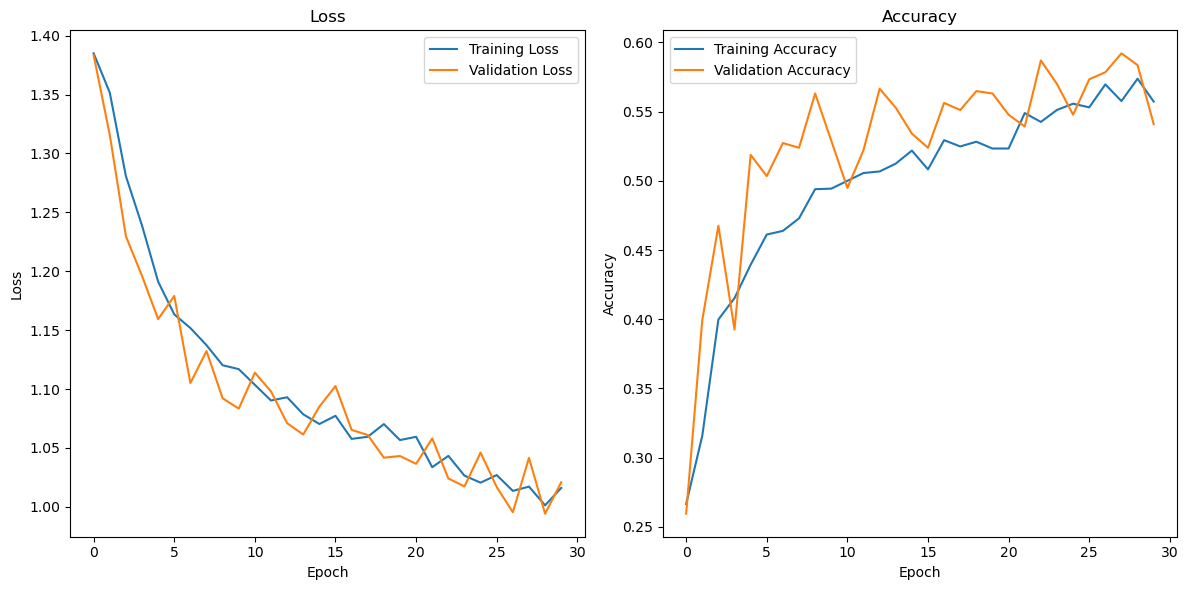

Model saved to model_LargeNet256_lr=0.001_epochs=30_batch=128.pth
Time elapsed: 14.395085000000002
Getting data loaders for current config...
Time to get data loaders: 0.019368000000000052
Epoch 1/30 | Train Loss: 1.3860 | Validation Loss: 1.3834 | Train Acc: 0.2532 | Validation Acc: 0.2526 | Time: 0.6451
Epoch 2/30 | Train Loss: 1.3829 | Validation Loss: 1.3793 | Train Acc: 0.2800 | Validation Acc: 0.3464 | Time: 0.4898
Epoch 3/30 | Train Loss: 1.3744 | Validation Loss: 1.3777 | Train Acc: 0.2909 | Validation Acc: 0.2474 | Time: 0.4453
Epoch 4/30 | Train Loss: 1.3562 | Validation Loss: 1.3538 | Train Acc: 0.2747 | Validation Acc: 0.3328 | Time: 0.5015
Epoch 5/30 | Train Loss: 1.3378 | Validation Loss: 1.3404 | Train Acc: 0.3508 | Validation Acc: 0.3908 | Time: 0.4944
Epoch 6/30 | Train Loss: 1.3202 | Validation Loss: 1.3274 | Train Acc: 0.3907 | Validation Acc: 0.4283 | Time: 0.4731
Epoch 7/30 | Train Loss: 1.3055 | Validation Loss: 1.3164 | Train Acc: 0.3892 | Validation Acc: 0.4249 

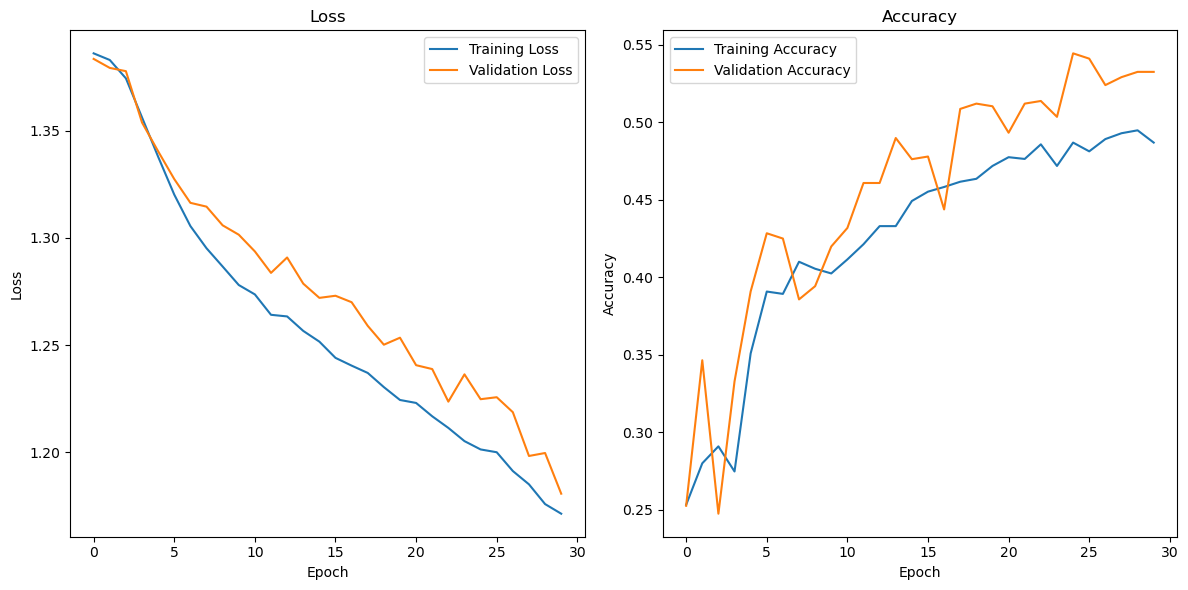

Model saved to model_LargeNet256_lr=0.0001_epochs=30_batch=64.pth
Time elapsed: 17.268374
Getting data loaders for current config...
Time to get data loaders: 0.17780499999999932
Epoch 1/30 | Train Loss: 1.3860 | Validation Loss: 1.3846 | Train Acc: 0.2592 | Validation Acc: 0.2645 | Time: 0.5015
Epoch 2/30 | Train Loss: 1.3853 | Validation Loss: 1.3856 | Train Acc: 0.2732 | Validation Acc: 0.2645 | Time: 0.4309
Epoch 3/30 | Train Loss: 1.3847 | Validation Loss: 1.3841 | Train Acc: 0.2566 | Validation Acc: 0.2577 | Time: 0.4971
Epoch 4/30 | Train Loss: 1.3836 | Validation Loss: 1.3838 | Train Acc: 0.2619 | Validation Acc: 0.2611 | Time: 0.5034
Epoch 5/30 | Train Loss: 1.3827 | Validation Loss: 1.3825 | Train Acc: 0.2611 | Validation Acc: 0.2577 | Time: 0.5672
Epoch 6/30 | Train Loss: 1.3814 | Validation Loss: 1.3814 | Train Acc: 0.2592 | Validation Acc: 0.2611 | Time: 0.5020
Epoch 7/30 | Train Loss: 1.3795 | Validation Loss: 1.3797 | Train Acc: 0.2664 | Validation Acc: 0.2577 | Time: 0.

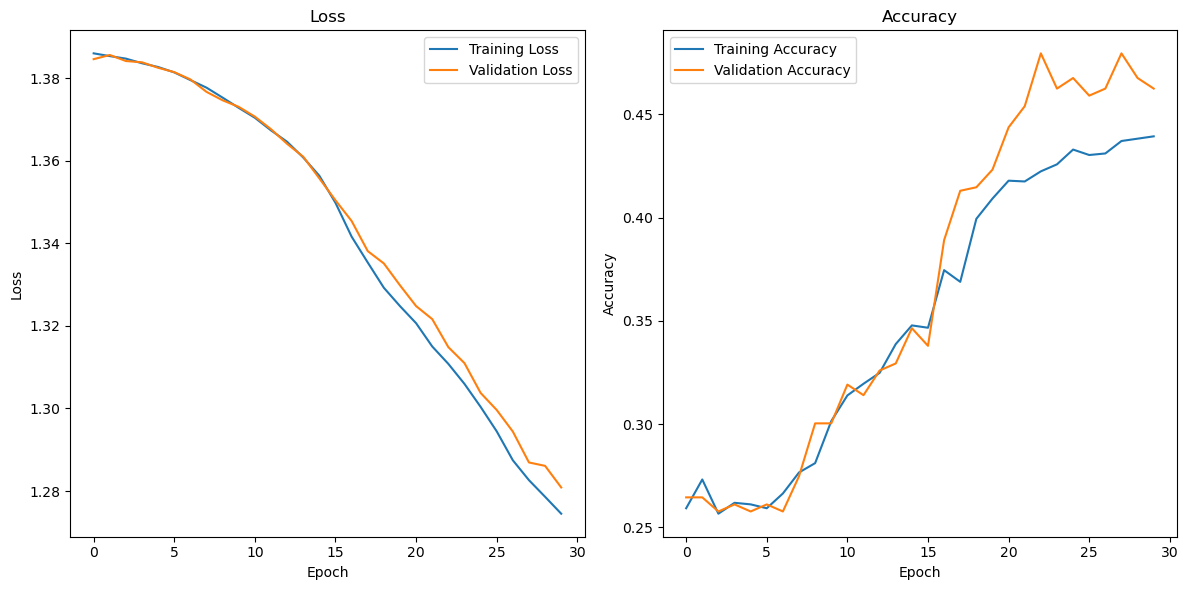

Model saved to model_LargeNet256_lr=1e-05_epochs=30_batch=64.pth
Time elapsed: 16.937953
Best performing model configuration: {'learning_rate': 0.001, 'num_epochs': 30, 'batch_size': 128}
With Validation Loss: 0.9942110776901245 and Validation Accuracy: 0.5836177474402731


In [12]:
import time

hyperparameter_configs = [
    {'learning_rate': 1e-3, 'num_epochs': 30, 'batch_size': 256},
    {'learning_rate': 1e-3, 'num_epochs': 30, 'batch_size': 128},
    {'learning_rate': 1e-4, 'num_epochs': 30, 'batch_size': 64},
    {'learning_rate': 1e-5, 'num_epochs': 30, 'batch_size': 64},
]

performance_tracking = []

for config in hyperparameter_configs:
    start = time.process_time()
    
    model = LargeNet256().to(device)

    print("Getting data loaders for current config...")
    train_loader, val_loader, test_loader = get_trash_data_loader(batch_size=config["batch_size"], img_dim=256)
    print(f"Time to get data loaders: {time.process_time() - start}")
           
    best_valid_loss, best_valid_acc = train(model, train_loader, val_loader, config)

    # Track the performance for each config
    performance_tracking.append({
        'config': config,
        'best_valid_acc': best_valid_acc,
        'best_valid_loss': best_valid_loss
    })

    # Save the model after training
    model_save_path = f"{path_to_project}model_LargeNet256_lr={config['learning_rate']}_epochs={config['num_epochs']}_batch={config['batch_size']}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    print(f"Time elapsed: {time.process_time() - start}")

# Determine best performing model
best_performance = sorted(performance_tracking, key=lambda x: x['best_valid_loss'])[0]
print("Best performing model configuration:", best_performance['config'])
print("With Validation Loss:", best_performance['best_valid_loss'], "and Validation Accuracy:", best_performance['best_valid_acc'])